In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/ML Project")

In [0]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

In [0]:
building =  pd.read_csv("ashrae-energy-prediction/building_metadata.csv")
weather = pd.read_csv("ashrae-energy-prediction/weather_train.csv")
train = pd.read_csv("ashrae-energy-prediction/train.csv")

In [0]:
train.shape

NameError: ignored

In [0]:
def plot_missing(dataset,w):
  missing_df = dataset.isnull().sum(axis=0).reset_index()
  missing_df.columns = ['column_name', 'missing_count']
  missing_df = missing_df.loc[missing_df['missing_count']>0]
  missing_df = missing_df.sort_values(by='missing_count')

  ind = np.arange(missing_df.shape[0])
  width = 0.5
  fig, ax = plt.subplots(figsize=(12,w))
  rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
  ax.set_yticks(ind)
  ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
  ax.set_xlabel("Count of missing values")
  ax.set_title("Number of missing values in each column")
  plt.show()

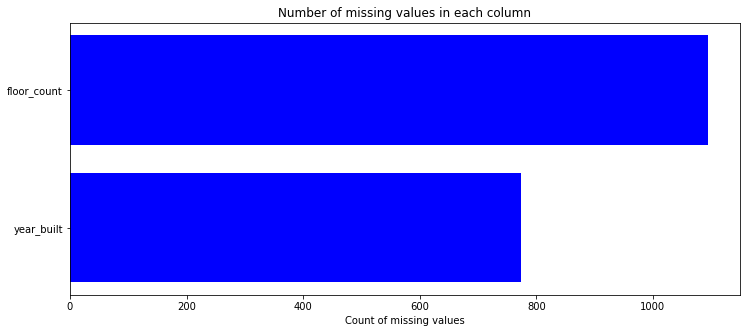

In [0]:
plot_missing(building,5)

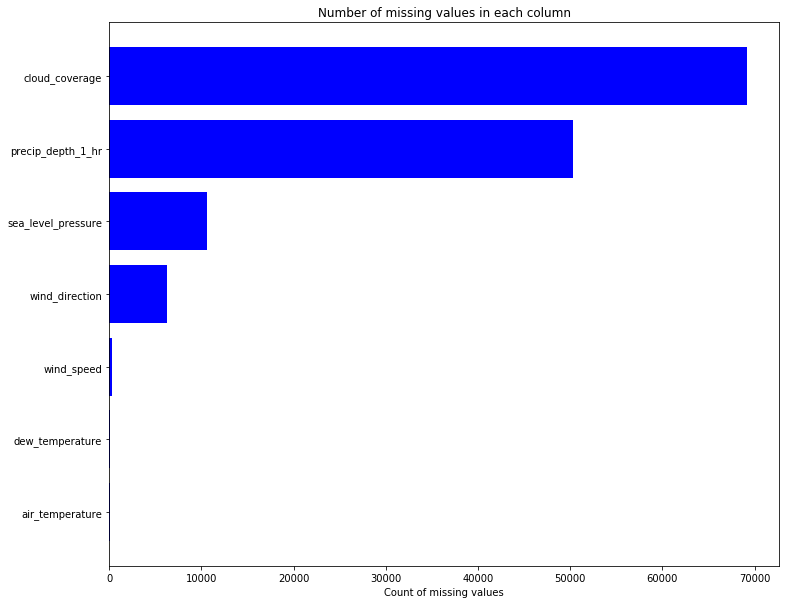

In [0]:
plot_missing(weather,10)

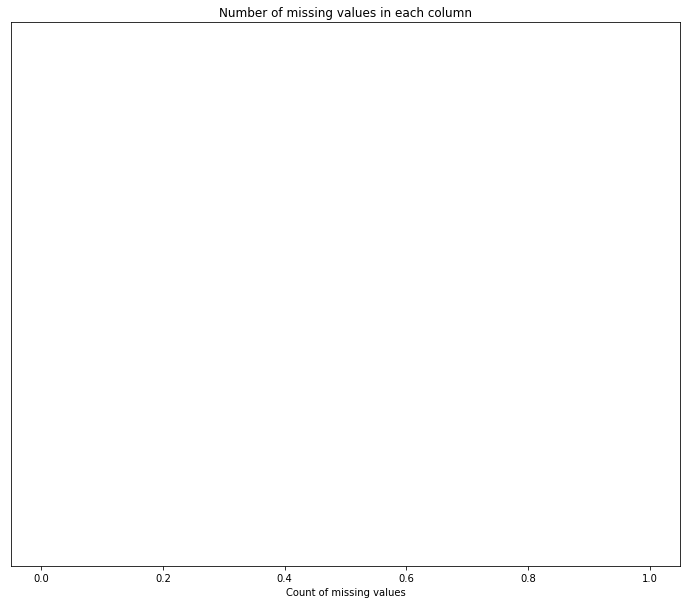

In [0]:
plot_missing(train,10)

In [0]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [0]:
building_df =  reduce_mem_usage(building)
weather_df = reduce_mem_usage(weather)
train_df = reduce_mem_usage(train)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [0]:
train = train_df.merge(building_df,on='building_id' ,how='left')
train = train.merge(weather_df,on=['site_id','timestamp'], how= 'left')

In [0]:
#filling out missing values
#calculating mean
floor_count_median=train.floor_count.median(axis=0,skipna=True)
year_built_median=train.year_built.median(axis=0,skipna=True)
#Filling the missing value in building to Median as we have outlier
air_temperature_median=train.air_temperature.median(axis=0,skipna=True)
cloud_coverage_median=weather.cloud_coverage.median(axis=0,skipna=True)
dew_temperature_median=train.dew_temperature.median(axis=0,skipna=True)
precip_depth_1_hr_median=train.precip_depth_1_hr.median(axis=0,skipna=True)
sea_level_pressure_median=train.sea_level_pressure.median(axis=0,skipna=True)
wind_direction_median=train.wind_direction.median(axis=0,skipna=True)
wind_speed_median=train.wind_speed.median(axis=0,skipna=True)

#filling values
train.floor_count.fillna(floor_count_median,inplace=True)
train.year_built.fillna(year_built_median,inplace=True)
#Filling the missing value in building to Median as we have outlier
train.air_temperature.fillna(air_temperature_median,inplace=True)
train.cloud_coverage.fillna(cloud_coverage_median,inplace=True)
train.dew_temperature.fillna(dew_temperature_median,inplace=True)
train.precip_depth_1_hr.fillna(precip_depth_1_hr_median,inplace=True)
train.sea_level_pressure.fillna(sea_level_pressure_median,inplace=True)
train.wind_direction.fillna(wind_direction_median,inplace=True)
train.wind_speed.fillna(wind_speed_median,inplace=True)

In [0]:
plot_hist(weather,'wind_direction')

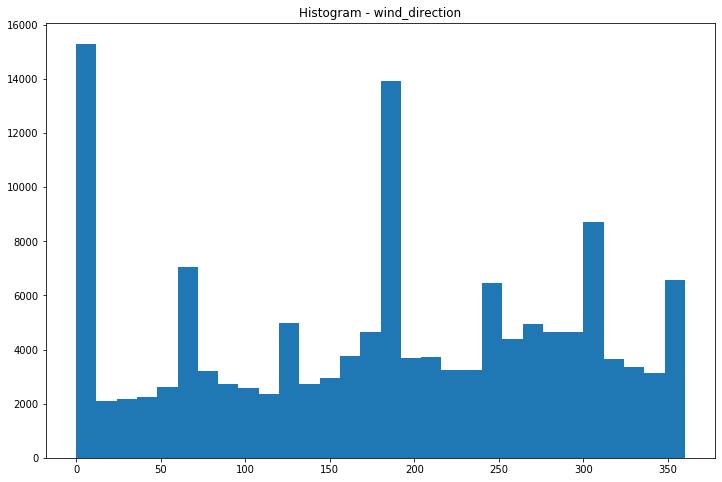

In [0]:
plot_hist(weather,'wind_direction')

In [0]:
def plot_hist(df,var_name):
    plt.figure(figsize=(12,8))
    plt.hist(df[var_name],bins = 30)
    plt.title(f"Histogram - {var_name}")
    plt.show()

In [0]:
trainfile = open("trainPickle",'ab')
pickle.dump(train,trainfile)
trainfile.close()

In [0]:
trainfile = open("trainPickle",'rb')
train = pickle.load(trainfile)
trainfile.close()

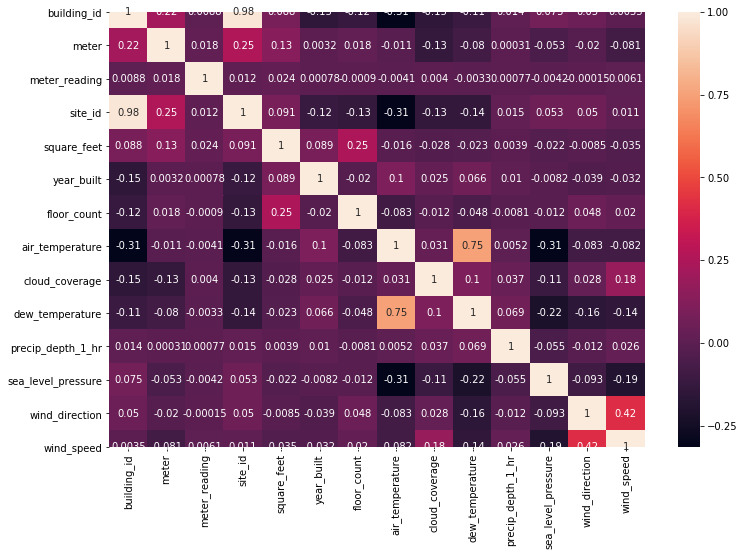

<Figure size 432x288 with 0 Axes>

In [0]:
import seaborn as sns
#Identify numerical columns to produce a heatmap
catcols = ['primary_use']
numcols = [x for x in train.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=train[numcols].corr(),annot = True)
plt.show()
plt.gcf().clear()

In [0]:
#DONT USE IT
# drop outlier bid= 1099 and meter= 2 if required
indexes = train[(train['building_id']==1099) & (train['meter']==2)].index.values
train.drop(index=indexes,inplace=True)

In [0]:
#Exp3 Split Timestamp
train['month'] = pd.to_datetime(train['timestamp']).dt.month
train['dayofweek'] = pd.to_datetime(train['timestamp']).dt.dayofweek
train['hourofday'] = pd.to_datetime(train['timestamp']).dt.hour

In [0]:
# Drop Columns building_id, timestamp
#Exp1 train.drop(['building_id','timestamp'],axis=1,inplace=True)
train.drop(['building_id','year_built','timestamp','floor_count','cloud_coverage','sea_level_pressure', 'wind_direction','precip_depth_1_hr'],axis=1,inplace=True)

In [0]:
#seperate the target Label
X  = train.loc[:,train.columns!='meter_reading']
Y  = train['meter_reading']
del train

In [0]:
#Encode categorical variable 
from sklearn import preprocesAsing
lb =preprocessing.LabelEncoder()
lb = lb.fit(X['primary_use'])
X['primary_use'] = lb.transform(X['primary_use'])

In [0]:
#divide training and test data
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.30,random_state=42)

In [0]:
#Normalize columns
def normalize(feature):
  feature = (feature  - feature.mean()) /feature.std()
  return feature

In [0]:
Xtrain.columns

Index(['meter', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'air_temperature', 'dew_temperature', 'wind_speed', 'month',
       'dayofweek', 'hourofday'],
      dtype='object')

In [0]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=30)
model.fit(Xtrain,Ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
print (model.max_depth)

17


In [0]:
#Compute the RMSLE
def RMSLE(pred,act): 
    return np.sqrt(np.sum((np.log(pred+1)-np.log(act+1))**2)/len(act))

In [0]:
#Training Predictions
y_predictTrain = model.predict(Xtrain)

In [0]:
#Testing Predictions
y_predictTest = model.predict(Xtest)

In [0]:
#Evaluating on training Data
res=RMSLE(y_predictTrain,Ytrain)
res

0.39485883575233166

In [0]:
#Evaluating on testing Data
res = RMSLE(y_predictTest,Ytest)
res

0.7858377344799493

In [0]:
test = pd.read_csv("ashrae-energy-prediction/test.csv")
weather_test = pd.read_csv("ashrae-energy-prediction/weather_test.csv")
building =  pd.read_csv("ashrae-energy-prediction/building_metadata.csv")

In [0]:
building_df =  reduce_mem_usage(building)
weather_df = reduce_mem_usage(weather_test)
test_df = reduce_mem_usage(test)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [0]:
test = test_df.merge(building,on='building_id' ,how='left')
test = test.merge(weather_test,on=['site_id','timestamp'], how= 'left')

In [0]:
#filling values
test.floor_count.fillna(floor_count_median,inplace=True)
test.year_built.fillna(year_built_median,inplace=True)
#Filling the missing value in building to Median as we have outlier
test.air_temperature.fillna(air_temperature_median,inplace=True)
test.cloud_coverage.fillna(cloud_coverage_median,inplace=True)
test.dew_temperature.fillna(dew_temperature_median,inplace=True)
test.precip_depth_1_hr.fillna(precip_depth_1_hr_median,inplace=True)
test.sea_level_pressure.fillna(sea_level_pressure_median,inplace=True)
test.wind_direction.fillna(wind_direction_median,inplace=True)
test.wind_speed.fillna(wind_speed_median,inplace=True)

In [0]:
test['month'] = pd.to_datetime(test['timestamp']).dt.month
test['dayofweek'] = pd.to_datetime(test['timestamp']).dt.dayofweek
test['hourofday'] = pd.to_datetime(test['timestamp']).dt.hour

In [0]:
test.drop(['building_id','timestamp','year_built','floor_count','cloud_coverage','sea_level_pressure', 'wind_direction','precip_depth_1_hr'],axis=1,inplace=True)

In [0]:
#Encode categorical variable 
test['primary_use'] = lb.transform(test['primary_use'])

In [0]:
org_test = test.copy()

In [0]:
test.drop(['row_id'],axis=1,inplace=True)

In [0]:
org_test.columns

Index(['row_id', 'meter', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'air_temperature', 'dew_temperature', 'wind_speed',
       'month', 'dayofweek', 'hourofday'],
      dtype='object')

In [0]:
predictions = model.predict(test)

In [0]:
#np.savetxt("predictions",predictions,delimiter=',')
submission = pd.DataFrame({'row_id':org_test['row_id'],'meter_reading':predictions})
submission.to_csv("submission",index=False)

In [0]:
pd.read_csv("submission")

,row_id,meter_reading
0,0,0.000000
1,1,0.438963
2,2,0.010215
3,3,0.000000
4,4,0.000000
...,...,...
41697595,41697595,13.653014
41697596,41697596,5.216487
41697597,41697597,8.821747
41697598,41697598,187.326047
